In [1]:
import numpy as np 
import emcee
import corner
import h5py
from sunpy.coordinates.sun import carrington_rotation_time
import astropy.units as u
import os
import scipy

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

## Bayesian Inference and Markov Chain Monte Carlo for the Ambient Solar Wind Speed

In this problem, we use Bayesian inference and Markov Chain Monte Carlo (MCMC) to find the parameters of
a chain of models that are used in space weather operational forecasting (of the ambient solar wind velocity near Earth). The model and data are connected by 
$$
\mathbf{y} = \mathcal{M}(\mathbf{\theta}) + \mathbf{\eta}
$$
where $\mathbf{\theta} = \{v_{1}, \alpha, \beta, w, \gamma\} \in \mathbb{R}^{5}$ is the set of uncertain parameters, $\mathcal{M}$ is the chain of *PFSS-WSA-HUX* models, $\mathbf{\eta}$ represents the discrepancies between the model and data, and is typically assumed to be Gaussian distributed with mean zero and covariance matrix $\mathbf{\Sigma}$ (positive definite), and $\mathbf{y}$ is the the radial velocity in 1hr cadance interval at L1. The radial velocity at L1 is meassured via SWEPAM monior on ACE. 

### Formulation of Bayesian posterior distribution for the model parameters $\mathbf{\theta} = [v_{1}, \alpha, \beta, w, \gamma]$ given the above information.


The prior is given by 
$$
\mathbb{P}(\theta) = \mathbb{P}(v_{1})\mathbb{P}(\alpha)\mathbb{P}(\beta)\mathbb{P}(w)\mathbb{P}(\gamma) = \left\{
\begin{array}{ll}
      \frac{1}{44.22} & \qquad 550 \leq v_{1} \leq 950, \qquad 0.05 \leq \alpha \leq 0.5, \qquad 1\leq \beta \leq 1.75, \qquad 0.01 \leq w \leq 0.4, \qquad 0.06 \leq \gamma \leq 0.9 \\
      0 & \text{otherwise} \\
\end{array} 
\right. 
$$
since the uncertain parameters $v_{1}, \alpha, \beta, w, \gamma$ are independent.

The posterior is given by (from Bayes' rule):
$$
\mathbb{P}(\theta | \mathbf{y}) = \frac{\mathbb{P}(\mathbf{y}|\theta) \mathbb{P}(\theta)}{\mathbb{P}(\mathbf{y})} = \frac{\mathbb{P}(\mathbf{y}|\theta) \mathbb{P}(\theta)}{\int_{\mathbb{R}^{7}} \mathbb{P}(\mathbf{y}|\theta)\mathbb{P}(\theta)\text{d}\mathbf{y}} \propto \mathbb{P}(\mathbf{y}|\theta) \mathbb{P}(\theta) 
$$


The log-posterior is given by 
$$
\log{\mathbb{P}(\theta | \mathbf{y})} = \log{\frac{\left[\mathbb{P}(\mathbf{y}|\theta) \mathbb{P}(\theta)\right]}{\int_{\mathbb{R}^{7}} \mathbb{P}(\mathbf{y}|\theta)\mathbb{P}(\theta)\text{d}\mathbf{y}}} = \log{\mathbb{P}(\mathbf{y}|\theta)} + \log{\mathbb{P}(\theta)} - \log{\int_{\mathbb{R}^{7}} \mathbb{P}(\mathbf{y}|\theta)\mathbb{P}(\theta)\text{d}\mathbf{y}}
$$

The log-prior is given by 
$$
\log{\mathbb{P}(\theta)} = \left\{
\begin{array}{ll}
      \log{\frac{1}{22.4}} &\qquad 550 \leq v_{1} \leq 950, \qquad 0.05 \leq \alpha \leq 0.5, \qquad 1\leq \beta \leq 1.75, \qquad 0.01 \leq w \leq 0.4, \qquad 0.06 \leq \gamma \leq 0.9 \\
      -\infty & \text{otherwise} \\
\end{array} 
\right. 
$$


The likelihood function  updates our belief state by measuring the misfit between the data $\mathbf{y}$ and model predictions $\mathcal{M}(\mathbf{\theta})$ with a specific parameter set. Since we assume additive Gaussian measurement noise wth zero mean, i.e. $\eta_j  \in \mathcal{N}(\mathbf{\mu}= \mathbf{0},\mathbf{\Sigma})$, the measurements are $\mathbf{y}_{j}$ independent across observations, conditional on the parameters $\mathbf{\theta}$, i.e., $\mathbf{y}_{1}$ and $\mathbf{y}_{2}$ are independent given $\mathbf{\theta}_{1}$ and $\mathbf{\theta}_{2}$. Using the independence assumption, we can write the likelihood function as
$$
\mathbb{P}(\mathbf{y}|\theta) =  \prod_{i=1}^{n} \frac{1}{(2\pi)^{7/2} |\mathbf{\Sigma}|^{1/2}} \exp \left( - \frac{1}{2}\left(\mathbf{y}_{i} - \mathcal{M}(\theta)\right)^{\top} \mathbf{\Sigma}^{-1} \left(\mathbf{y}_{i} - \mathcal{M}(\theta)\right)\right) \propto  \exp \left( -\sum_{i=1}^{n} \frac{1}{2}\left(\mathbf{y}_{i} - \mathcal{M}(\theta)\right)^{\top} \mathbf{\Sigma}^{-1} \left(\mathbf{y}_{i} - \mathcal{M}(\theta)\right)\right).
$$

### MCMC
MCMC is a procedure for generating a random walk in the parameter space that, over time, draws a representative set of samples from the distribution. Each point in a Markov chain $X(t_{i})$ depends only on the position of the previous step $X(t_{i−1})$. The emcee method involves simultaneously evolving an ensemble of $K$ walkers $S = {X_{k}}$ where the proposal distribution for one walker $k$ is based on the current positions of the $K − 1$ walkers in the complementary ensemble $S_{[k]} = \{X_{j} , \forall j\neq k\}$. Here, we use a Python implemtation of the affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC) proposed by Goodman & Weare (2010).

In [8]:
reader = emcee.backends.HDFBackend("MCMC_results/CR_total_without_pfss_sigma_80_CR_2053.h5")

nburnin = 0
samples = reader.get_chain(flat=False, discard=nburnin)
samples_flatten  = reader.get_chain(flat=True, discard=nburnin)
log_prob_samples = reader.get_log_prob(flat=False, discard=nburnin)
log_prior_samples = reader.get_blobs(flat=False, discard=nburnin)

n_iter = np.shape(samples)[0]
n_walkers = np.shape(samples)[1]
n_dim = np.shape(samples)[2]

print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("num of iterations: {0}".format(reader.iteration))

AttributeError: You must run the sampler with 'store == True' before accessing the results

In [4]:
print("acceptance ratio:", np.mean(reader.accepted/(reader.iteration)))

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'MCMC_results/CR_total_without_pfss_sigma_80_CR_2052.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Log-likelihood in parameter space

NameError: name 'n_walkers' is not defined

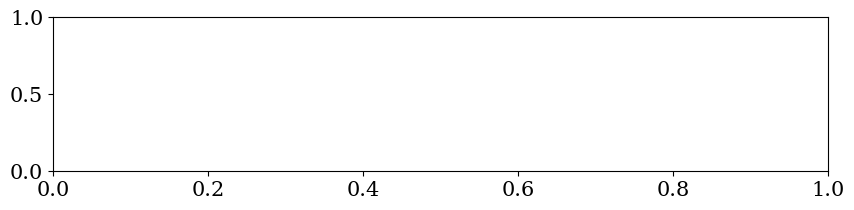

In [5]:
fig, ax = plt.subplots(figsize=(10, 2))
for ii in range(n_walkers):
    _ = ax.plot(-log_prob_samples[:, ii])
_ = ax.set_yscale("log")
#_ = ax.set_xlim(1, n_iter)
_ = ax.set_ylabel("Likelihood")
_ = ax.set_xlabel("Number of iterations")

### A corner plot to show correlation (or lack thereof) of the seven model parameters.

In [17]:
labels_list = [r"$v_{1}$", r"$\alpha$", r"$\beta$", r"$w$", r"$\gamma$"]
MAP = []
fig = corner.corner(samples_flatten, figsize=(4, 3), 
                    fontsize=30, smooth=1, 
                    no_fill_contours=True, plot_contours=True, 
                    plot_density ="bone_r",
                    color="darkblue",
                    fill_contours=True, 
                    plot_datapoints=False)

# Extract the axes
axes = np.array(fig.axes).reshape((n_dim, n_dim))

for ii in range(n_dim):
    ax = axes[ii, ii]
    ax.clear()
    mu, sigma = scipy.stats.norm.fit(np.ndarray.flatten(samples[:,:, ii]))
    n , bins, _ = ax.hist(np.ndarray.flatten(samples[:,:, ii]), 
                          25, density=1, 
                          color="darkblue", 
                          linewidth=3, 
                         alpha=0.4)
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    ax.set_ylim(np.min(best_fit_line), np.max(best_fit_line)*2)
    ax.set_xlim(np.min(bins), np.max(bins))
    _ = ax.plot(bins, best_fit_line, c="black", linewidth=2)
    ax.set_xticks([])
    ax.set_yticks([])
    MAP.append(bins[np.where(n == n.max())])
    ax.axvline(bins[np.where(n == n.max())], label="$MAP$", color="lightblue", ls="--", linewidth=3)
    ax.set_title("MAP = " + str(round(bins[np.where(n == n.max())][0], 2))
                 +"\n $\sigma = $" + "{:.2e}".format(np.std(samples[:,:, ii])), fontsize=18)

# Loop over the histograms
for yi in range(n_dim):
    for xi in range(n_dim):
        if xi < yi:
            ax = axes[yi, xi]
            ax.axvline(MAP[xi], color="lightblue", ls="--", linewidth=3)
            ax.axhline(MAP[yi], color="lightblue", ls="--", linewidth=3)
            if yi==4:
                ax.set_xlabel(labels_list[xi], fontsize=23)
            if xi==0:
                ax.set_ylabel(labels_list[yi], fontsize=23)
            ax.set_xticks([])
            ax.set_yticks([])
            
axes[-1, -1].set_xticks([])
axes[-1, -1].set_xlabel(labels_list[-1], fontsize=23)
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("figs/MCMC/mcmc_corner_plot_five_uncertain_parameters_three_CRs.png", dpi=500, bbox_inches='tight')

NameError: name 'samples_flatten' is not defined

## Diagnostics for MCMC

**1) Mixing of the Chain (Heuristic):**
Good mixing occurs when more of the domain is explored. Bad mixing occurs when the step size is too large and most proposals are rejected, resulting in less space being explored. 

In [18]:
fig, ax = plt.subplots(nrows=n_dim, sharex=True, figsize=(7, 8))

for ii in range(n_dim):
    ax[ii].plot(samples[:,:, ii], '-', alpha=0.3)
    ax[ii].set_ylabel(labels_list[ii], fontsize=17)
    
ax[-1].set_xlabel("Number of Samples")
# #ax[0].set_title("Walkers in Parameter Space")
# ax[0].set_yticks([650, 710])
# ax[1].set_yticks([1.813*0.1, 1.817*0.1])
# ax[2].set_yticks([1.01, 1.06])
# ax[3].set_yticks([0.01445, 0.01441])
# ax[4].set_yticks([0.24, 0.25])

ax[0].set_xlim(0, n_iter)

fig.subplots_adjust(wspace=0, hspace=0)
#ax[-1].set_xticks(np.arange(0, n_iter))
#plt.tight_layout()
plt.savefig("figs/MCMC/MCMC_chain_five_parameters_three_CRs.png", dpi=500, bbox_inches='tight')

NameError: name 'n_dim' is not defined

# **2) Autocorrelation:** Autocorrelation draws from the fundamental property of a Markov chain: *every Markov chain is memoryless*. We can compute the autocorrelation of states which are $\ell$ iterations apart as
$$
R(\ell) \equiv \frac{\sum_{i=1}^{n-\ell} (X_{i} -\bar{X})(X_{i+\ell} - \bar{X})}{\sum_{i=1}^{n} (X_{i} - \bar{X})^2}
$$
where $\bar{X}$ is the mean.

In [19]:
fig, ax = plt.subplots(ncols=n_dim, sharey=True, figsize=(15, 3))
for jj in range(n_dim):
    for ii in np.arange(0, n_walkers):
        ax[jj].plot(emcee.autocorr.function_1d(samples[:, ii, jj].T))
        ax[jj].set_xlabel("$\ell$")
        ax[jj].hlines(0, xmin=0, xmax=len(samples[:, 0, 0]), color="k", ls="--")
    ax[jj].set_title(str(labels_list[jj]))
ax[0].set_ylabel("$R(\ell)$")

plt.tight_layout()

NameError: name 'n_dim' is not defined

**3) Integrated Autocorrelation (IAC) and Effective Sample Size (ESS):** In standard MC, the variance of the estimator is 
$$
\mathbb{V}\text{ar} \left( \frac{1}{N} \sum_{i=1}^{N} f(X^{(i)})\right) = \frac{\mathbb{V}\text{ar}(f(X))}{N}, \qquad X^{(i)} \sim i.i.d.
$$
In MCMC, samples are correlated, so we get additional covariance terms. If we assume that all $X_{i}$ and $X_{j}$ are samples from the target distribution, then we can approximate the variance of the MCMC estimator as 
$$
\mathbb{V}\text{ar}\left(\bar{f}(X)^{\text{MCMC}}\right) = \mathbb{V}\text{ar} \left( \frac{1}{N} \sum_{i=1}^{N} f(X^{(i)})\right) = \frac{\mathbb{V}\text{ar}\left(f(X) \right)}{N} \cdot \theta
$$
where the integrated autocorrelation (IAC) $\theta$ is defined as 
$$
\theta = \sum_{\tau=-\infty}^{\infty} \rho_{f}(\tau)
$$
where $\rho_{f}(\tau)$ is the normalized autocorrelation function of the stochastic process that generated the chain for $f$. You can estimate $\rho_{f}(\tau)$ using a finite chain $\{ f_{n}\}_{n=1}^{N}$ as 
$$
\hat{\rho}_{f}(\tau) = \hat{c}_{f}(\tau)/\hat{c}_{f}(0)
$$
where 
$$
\hat{c}_{f}(\tau) = \frac{1}{N-\tau} \sum_{n=1}^{N-\tau} (f_{n} - \mu_{f}) (f_{n+\tau} - \mu_{f})
$$
and 
$$
\mu_{f} = \frac{1}{N} \sum_{n=1}^{N} f_{n}.
$$
We stimate $\theta$ using the estimator for $\rho_{f}(\tau)$ as 
$$
\theta(M) = 1 + 2 \sum_{\tau=1}^{M} \hat{\rho}_{f}(\tau)
$$
The effective sample size of MCMC is then $\frac{N}{\theta}$ and we want $\frac{N}{\theta} \ll 1$. Essentially, $\theta$ is the number of steps that are needed fbefore the chain "forgets" where it started. Once we estimate $\theta$ then we can estimate the number of samples that we need to generate to reduce the relative error on the target inegral. Typically, parallel chains longer than $50\theta$ are often sufficient. 

The integrated autocorrelation time is an estimate of the number of steps needed in the chain in order to draw independent samples from the target density. A more efficient chain has a shorter autocorrelation time.

In [20]:
tau = reader.get_autocorr_time(discard=nburnin)
print("More than N=" + str(np.max(tau*50)) + " samples in each chain is sufficient.")

AttributeError: You must run the sampler with 'store == True' before accessing the results